# walkthrough of an vine copula (vinecop) application on financial (US ETFs) dependence modeling and simulation.

- data preprocessing and exploratory data analysis
- make marginal cdf/ppf, transform from raw return to copula data
- fit 'rvine', draw, do full simulation
- fit 'cvine', draw, do cond simulation (given **SPY** scenario)


## initialization, fetch data, preprocess


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yfinance as yf

import torchvinecopulib as tvc

lst_ticker = [
    "SPY",
    "QQQ",
    "DIA",
    "IJH",
    "VTI",
    "IWM",
    "XLF",
    "XLE",
    "XLK",
    "EFA",
    "EWA",
    "EWJ",
    "EEM",
    "FXI",
    "AGG",
    "TLT",
    "GLD",
    "SLV",
    "USO",
    "UNG",
]
print(lst_ticker)
raw_df = yf.download(lst_ticker, start="2010-01-01")
raw_df.index = pd.DatetimeIndex(raw_df.index)
raw_df = raw_df["Adj Close"].ffill()
# calc simple retn
NUM_DAY_INTVL = 1
df_retn_adjclose_simple_last_intvl = np.expm1(np.log(raw_df)[::NUM_DAY_INTVL].diff(1).dropna())
#
NUM_SIM = 50000
print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

['SPY', 'QQQ', 'DIA', 'IJH', 'VTI', 'IWM', 'XLF', 'XLE', 'XLK', 'EFA', 'EWA', 'EWJ', 'EEM', 'FXI', 'AGG', 'TLT', 'GLD', 'SLV', 'USO', 'UNG']


[*********************100%%**********************]  20 of 20 completed

cuda (GPU) avail? True



### chart rolling bidep between each asset and SPY


In [2]:
f_bidep = tvc.util.kendall_tau
dct_dep_spy = {}
for df in df_retn_adjclose_simple_last_intvl.rolling(
    window=252 // NUM_DAY_INTVL, step=int(np.sqrt(252) // NUM_DAY_INTVL)
):
    if df.shape[0] >= 252 // NUM_DAY_INTVL:
        dct_dep_spy[df.index[-1]] = {
            k: f_bidep(torch.from_numpy(df[[k]].values), torch.from_numpy(df[["SPY"]].values))
            for k in df.keys()
        }

Text(0.5, 1.0, 'Rolling bivariate dependence (kendall_tau), between ETFs and SPY.')

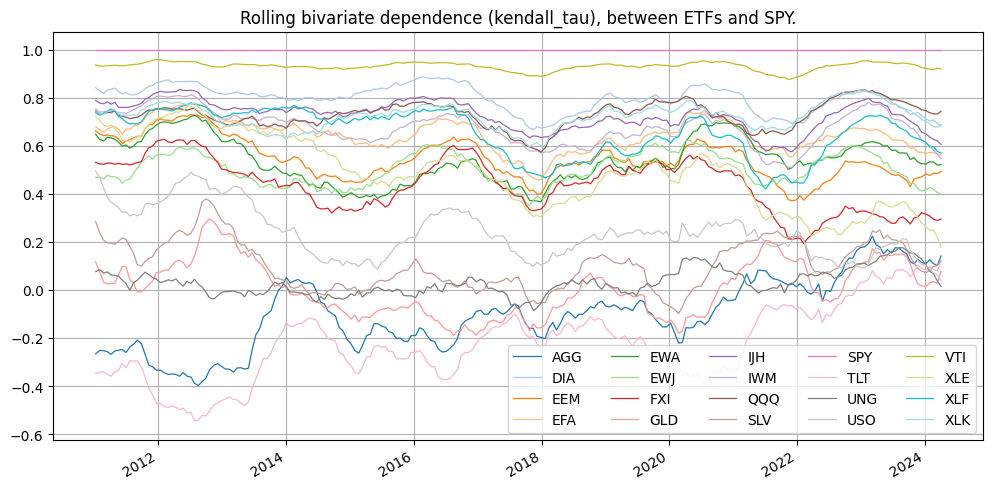

In [3]:
pd.DataFrame(dct_dep_spy).T.plot(figsize=(12, 6), style="-", alpha=1, lw=0.9, colormap="tab20")
plt.legend(ncol=5)
plt.grid()
plt.title(f"Rolling bivariate dependence ({f_bidep.__name__}), between ETFs and SPY.")

### make marginal cdf_ppf functions; transform from raw data (-∞,∞)-> copula data (0,1)


In [4]:
from scipy import stats
from random import seed as r_seed
from scipy.special import ndtr
from scipy.interpolate import CubicSpline


def make_cdf_ppf(
    vec_obs: np.array,
    mtd_margin: str,
    seed: int,
    lst_distribution: list = [
        stats.t,
        stats.nct,
        stats.johnsonsu,
        stats.tukeylambda,
    ],
) -> pd.Series:
    """fit marginal univariate distributions, return fitted cdf/ppf functions
    # ! band_width for np fit from:
    Dhaker, H., Deme, E. H., & Ciss, Y. (2021).
    β-Divergence loss for the kernel density estimation with bias reduced.
    Statistical Theory and Related Fields, 5(3), 221-231.
    """
    r_seed(seed)
    np.random.seed(seed=seed)
    vec_clean = np.sort(vec_obs[np.isfinite(vec_obs)])
    if mtd_margin == "np":
        # The constant has beta = 1.7320508075688772 from
        # (4 * beta**4 / (9 * beta**4 - 36 * beta**3 + 90 * beta**2 + 270 * beta + 105) * sqrt(2 / pi))**(1 / 9)
        band_width = vec_clean.std() * 0.6973425390765554 * (len(vec_clean)) ** (-1 / 9)

        # empirical cdf, semi parametric approach, from mixture
        @np.vectorize
        def res_cdf(quantile: np.array):
            # ±∞ return to (0,1) cdf
            return ndtr((quantile - vec_clean) / band_width).mean()

        vec_F, idx = np.unique(res_cdf(vec_clean), return_index=True)
        func_spline = CubicSpline(x=vec_F, y=vec_clean[idx])

        def res_ppf(percentage: np.array):
            # (0,1) cdf to ±∞ return
            return func_spline(percentage)

    elif mtd_margin == "p":
        dist, par, bic2, lnn2 = None, None, np.inf, np.log(len(vec_clean)) / 2
        for iter_dist in lst_distribution:
            iter_par = iter_dist.fit(vec_clean)
            iter_bic2 = len(iter_par) * lnn2 - iter_dist.logpdf(vec_clean, *iter_par).sum()
            if iter_bic2 < bic2:
                dist, par, bic2 = iter_dist, iter_par, iter_bic2
        res_cdf, res_ppf = lambda vec: dist.cdf(vec, *par), lambda vec: dist.ppf(vec, *par)

    return pd.Series({"cdf": res_cdf, "ppf": res_ppf})

In [5]:
arr_cdf_ppf = np.apply_along_axis(
    func1d=lambda vec: make_cdf_ppf(vec_obs=vec, mtd_margin="np", seed=0),
    axis=0,
    arr=df_retn_adjclose_simple_last_intvl.values,
)

In [6]:
V_mvcp = torch.as_tensor(
    np.hstack(
        [
            cdf(df_retn_adjclose_simple_last_intvl.values[:, [idx]])
            for idx, cdf in enumerate(arr_cdf_ppf[0])
        ]
    ),
    device=DEVICE,
)
print(V_mvcp.min(), V_mvcp.max())

tensor(0.0001, device='cuda:0', dtype=torch.float64) tensor(0.9999, device='cuda:0', dtype=torch.float64)


## dvine, full sim
> make dvine from multivariate copula observations, **full sim**

In [7]:
# read lst_sim from right to left
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp)

print(mdl_vcp)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_594,
 'num_par': 167,
 'negloglik': -56457.6707,
 'aic': -112581.3415,
 'bic': -111548.1089,
 'matrix': '[[ 5 14  0 13 18  1 19  9 15 10 17  8 12 16  7 11  6  2  4  3]'
           ' [-1  6 14  0 13 18  1 19  9 15 10 17  8 12 16  7 11  4  3  2]'
           ' [-1 -1  7 14  0 13 18  1 19  9 15 10 17  8 12 16  2  3  4 11]'
           ' [-1 -1 -1 11 14  0 13 18  1 19  9 15 10 17  8 12 16  2  3  4]'
           ' [-1 -1 -1 -1  4 14  0 13 18  1 19  9 15 10 17  8 12 16  2  3]'
           ' [-1 -1 -1 -1 -1  2 14  0 13 18  1 19  9 15 10 17  8 12 16  3]'
           ' [-1 -1 -1 -1 -1 -1  3 14  0 13 18  1 19  9 15 10 17  8 12 16]'
           ' [-1 -1 -1 -1 -1 -1 -1 14 15 17  9  8 19 16 10 12  1 18  0 13]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1  0 15 17  9  8 19 16 10 12  1 18 13]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 13 15 17  9  8 19 16 10 12  1 18]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 15 18  1 19  9 10 12 16  8 17]'
          

In [8]:
for _ in enumerate(df_retn_adjclose_simple_last_intvl.columns):
    print(_)

(0, 'AGG')
(1, 'DIA')
(2, 'EEM')
(3, 'EFA')
(4, 'EWA')
(5, 'EWJ')
(6, 'FXI')
(7, 'GLD')
(8, 'IJH')
(9, 'IWM')
(10, 'QQQ')
(11, 'SLV')
(12, 'SPY')
(13, 'TLT')
(14, 'UNG')
(15, 'USO')
(16, 'VTI')
(17, 'XLE')
(18, 'XLF')
(19, 'XLK')


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x236653d3790>)

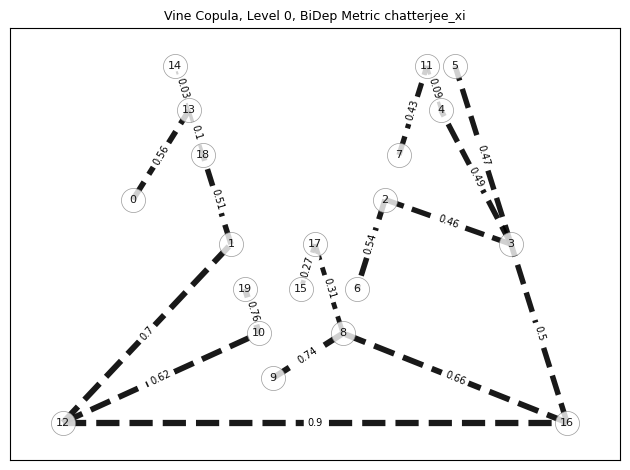

In [9]:
# SPY is vertex 12
mdl_vcp.draw_lv()

In [10]:
print(mdl_vcp.lst_sim)
V_sim = mdl_vcp.sim(num_sim=NUM_SIM, device=DEVICE)
print(V_sim)

[5, 6, 7, 11, 4, 2, 3, 14, 0, 13, 15, 17, 9, 8, 18, 1, 16, 12, 10, 19]
tensor([[0.6109, 0.9301, 0.9304,  ..., 0.9403, 0.9065, 0.8805],
        [0.2682, 0.4621, 0.8913,  ..., 0.9086, 0.9948, 0.6501],
        [0.4803, 0.5241, 0.5720,  ..., 0.8760, 0.2074, 0.4968],
        ...,
        [0.4405, 0.4563, 0.9125,  ..., 0.8411, 0.5569, 0.9686],
        [0.0320, 0.2965, 0.2256,  ..., 0.7657, 0.2330, 0.1111],
        [0.7824, 0.1951, 0.2123,  ..., 0.3051, 0.2556, 0.3140]],
       device='cuda:0', dtype=torch.float64)


In [11]:
arr_sim = np.hstack([ppf(V_sim[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])])

print(arr_sim.min(), arr_sim.max())
print(
    "\nkendall tau wrt SPY, of simulations",
    pd.DataFrame(arr_sim, columns=df_retn_adjclose_simple_last_intvl.columns).corr(
        method="kendall"
    )["SPY"],
)
print(
    "\nkendall tau wrt SPY, of raw obs",
    df_retn_adjclose_simple_last_intvl.corr(method="kendall")["SPY"],
)

-0.26322005760826317 0.32582054903052715

kendall tau wrt SPY, of simulations Ticker
AGG   -0.086502
DIA    0.794166
EEM    0.554076
EFA    0.645153
EWA    0.561476
EWJ    0.502386
FXI    0.430386
GLD    0.035692
IJH    0.723346
IWM    0.670278
QQQ    0.733915
SLV    0.133525
SPY    1.000000
TLT   -0.213358
UNG    0.033165
USO    0.258714
VTI    0.931336
XLE    0.476948
XLF    0.653208
XLK    0.720998
Name: SPY, dtype: float64

kendall tau wrt SPY, of raw obs Ticker
AGG   -0.083248
DIA    0.795148
EEM    0.549107
EFA    0.645348
EWA    0.549569
EWJ    0.500580
FXI    0.430146
GLD    0.023779
IJH    0.725185
IWM    0.674963
QQQ    0.735381
SLV    0.129622
SPY    1.000000
TLT   -0.208628
UNG    0.037757
USO    0.233737
VTI    0.931977
XLE    0.467955
XLF    0.647446
XLK    0.724794
Name: SPY, dtype: float64


## rvine, cond sim
> make rvine from multivariate copula observations, **cond sim**

In [12]:
# user specify the priority vertices list, used in fitting and also in the conditional simulation
mdl_vcp_cond = tvc.vinecop.vcp_from_obs(
    V_mvcp,
    mtd_vine="rvine",
    lst_first=[12],
)

print(mdl_vcp_cond)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_594,
 'num_par': 167,
 'negloglik': -56457.6707,
 'aic': -112581.3415,
 'bic': -111548.1089,
 'matrix': '[[ 5 14  0 13 18  1 19  9 15 10 17  8 12 16  7 11  6  2  4  3]'
           ' [-1  6 14  0 13 18  1 19  9 15 10 17  8 12 16  7 11  4  3  2]'
           ' [-1 -1  7 14  0 13 18  1 19  9 15 10 17  8 12 16  2  3  4 11]'
           ' [-1 -1 -1 11 14  0 13 18  1 19  9 15 10 17  8 12 16  2  3  4]'
           ' [-1 -1 -1 -1  4 14  0 13 18  1 19  9 15 10 17  8 12 16  2  3]'
           ' [-1 -1 -1 -1 -1  2 14  0 13 18  1 19  9 15 10 17  8 12 16  3]'
           ' [-1 -1 -1 -1 -1 -1  3 14  0 13 18  1 19  9 15 10 17  8 12 16]'
           ' [-1 -1 -1 -1 -1 -1 -1 14 15 17  9  8 19 16 10 12  1 18  0 13]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1  0 15 17  9  8 19 16 10 12  1 18 13]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 13 15 17  9  8 19 16 10 12  1 18]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 15 18  1 19  9 10 12 16  8 17]'
          

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x23665296bc0>)

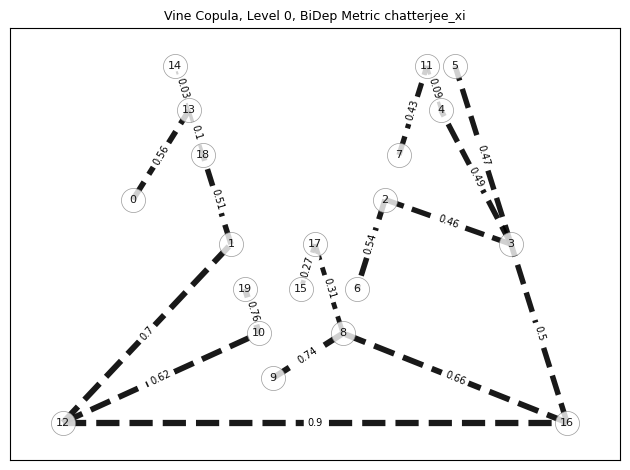

In [13]:
# SPY is vertex 12
mdl_vcp_cond.draw_lv()

In [14]:
# cond sim: user specified values for first set (vertex 12),
# a tail scenario with CDF(SPY)=.05
dct_first_vs = {(12, frozenset()): torch.ones(size=(NUM_SIM, 1), device=DEVICE) * (0.05)}
V_sim_cond = mdl_vcp.sim(num_sim=NUM_SIM, dct_first_vs=dct_first_vs, device=DEVICE)
arr_sim_cond = np.hstack(
    [ppf(V_sim_cond[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])]
)
print("specified value of SPY:", arr_sim_cond[:, 12])
print(arr_sim_cond[:3, :])

specified value of SPY: [-0.01724445 -0.01724445 -0.01724445 ... -0.01724445 -0.01724445
 -0.01724445]
[[ 0.00585247 -0.04580595 -0.04689723 -0.10152633 -0.16956953 -0.12524868
  -0.04999112 -0.01933971 -0.00602463  0.00732608  0.02071315 -0.12581464
  -0.01724445  0.0246444  -0.02307279  0.17449474 -0.0044753  -0.01382656
  -0.09224989  0.01410141]
 [ 0.0042291  -0.01682531 -0.00024372 -0.00468005  0.00058825  0.01004983
   0.00442414  0.01723536 -0.02835935 -0.01216821 -0.00640634  0.01172493
  -0.01724445  0.01876948 -0.0222043  -0.04330636 -0.01709053 -0.03993103
  -0.02264866 -0.00778279]
 [ 0.01157604 -0.01962371 -0.01611838 -0.0186466  -0.02160365 -0.01163438
  -0.03163818  0.01188172 -0.02453121 -0.01549703 -0.00223071  0.01151745
  -0.01724445  0.03092404 -0.01583154 -0.02941072 -0.01772435 -0.04843678
  -0.03444926 -0.00044259]]
